Membuat file data dummy...
File dummy & label berhasil dibuat.

Langkah 1–3: Preprocessing dan TF Scoring

Langkah 4: Preprocessing Query
Querylist: ['tumbuh', 'ekonomi', 'kembang', 'pasar', 'gera', 'harga', 'saham']

Langkah 5: Hitung Skor Relevansi
Top 10 Dokumen:
data3.txt: 0.3750
data6.txt: 0.3750
data9.txt: 0.3750
data12.txt: 0.3750
data15.txt: 0.3750
data18.txt: 0.3750
data21.txt: 0.3750
data24.txt: 0.3750
data27.txt: 0.3750
data30.txt: 0.3750

Langkah 6: Membaca Label

Langkah 7: Precision & Recall
@1: Precision=1.00, Recall=0.06
@2: Precision=1.00, Recall=0.12
@3: Precision=1.00, Recall=0.19
@4: Precision=1.00, Recall=0.25
@5: Precision=1.00, Recall=0.31
@6: Precision=1.00, Recall=0.38
@7: Precision=1.00, Recall=0.44
@8: Precision=1.00, Recall=0.50
@9: Precision=1.00, Recall=0.56
@10: Precision=1.00, Recall=0.62

Langkah 8: Visualisasi Precision-Recall

Langkah 4: Preprocessing Query
Querylist: ['tumbuh', 'ekonomi', 'kembang', 'pasar', 'gera', 'harga', 'saham']

Langkah 5: Hitu

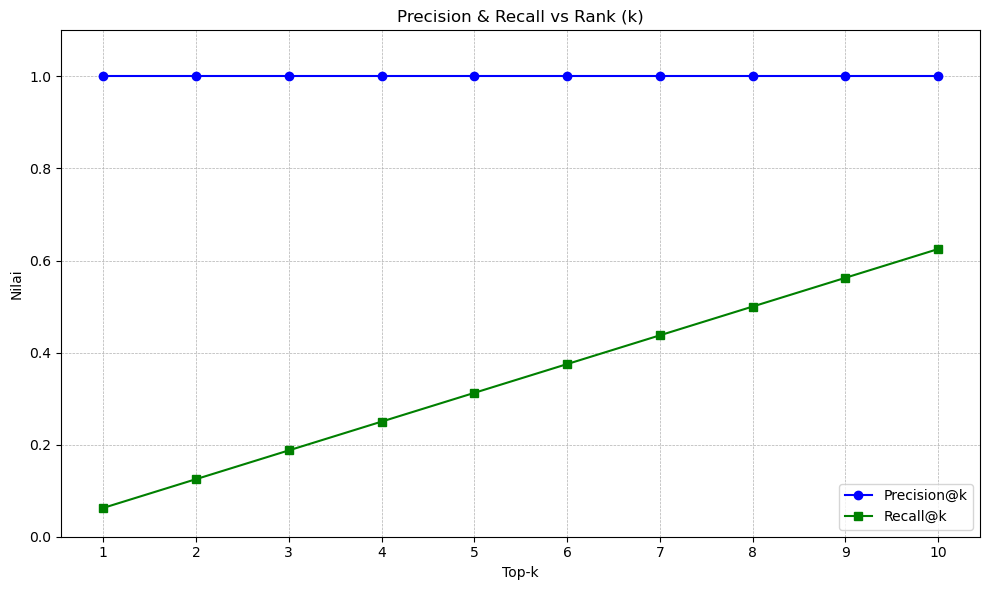

In [5]:
# Import Library
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Setup: Buat File Dummy dan Label
def create_dummy_files():
    print("Membuat file data dummy...")
    os.makedirs("data_files", exist_ok=True)

    content_ekonomi = "pertumbuhan ekonomi indonesia melambat akibat inflasi global. harga saham anjlok dan perkembangan pasar modal terganggu."
    content_olahraga = "timnas sepak bola indonesia menang di piala asia. performa pemain sangat bagus dan menjadi sorotan media."
    content_teknologi = "teknologi kecerdasan buatan berkembang pesat. banyak startup baru muncul dengan inovasi di bidang AI."

    labels = []
    for i in range(1, 51):
        filename = f"data{i}.txt"
        filepath = os.path.join("data_files", filename)

        if i % 3 == 0:
            content = content_ekonomi
            kategori = "ekonomi"
        elif i % 3 == 1:
            content = content_olahraga
            kategori = "olahraga"
        else:
            content = content_teknologi
            kategori = "teknologi"

        with open(filepath, "w", encoding="utf-8") as f:
            f.write(content + f" (sumber: data {i})")
        labels.append({"filename": filename, "kategori": kategori})

    pd.DataFrame(labels).to_csv("label.csv", index=False)
    print("File dummy & label berhasil dibuat.")

create_dummy_files()

# Inisialisasi NLP Tools
stemmer = StemmerFactory().create_stemmer()
stopword_remover = StopWordRemoverFactory().create_stop_word_remover()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = stopword_remover.remove(text)
    tokens = text.split()
    return [stemmer.stem(token) for token in tokens]

# Langkah 1–3: Baca, Preprocess, Hitung TF
print("\nLangkah 1–3: Preprocessing dan TF Scoring")
data_dir = "data_files"
all_docs_data = []

for i in range(1, 51):
    filename = f"data{i}.txt"
    filepath = os.path.join(data_dir, filename)

    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            data = f.read()
    except FileNotFoundError:
        continue

    keywords = preprocess_text(data)
    if not keywords:
        all_docs_data.append({'filename': filename, 'final_scores': {}})
        continue

    term_counts = Counter(keywords)
    total_terms = len(keywords)
    tf_scores = {term: count / total_terms for term, count in term_counts.items()}
    threshold = 0.5 * max(tf_scores.values())
    final_scores = {term: score for term, score in tf_scores.items() if score >= threshold}

    all_docs_data.append({
        'filename': filename,
        'final_scores': final_scores
    })

# Langkah 4: Preprocessing Query
print("\nLangkah 4: Preprocessing Query")
query_text = "pertumbuhan ekonomi, perkembangan pasar dan pergerakan harga saham"
query_kategori = "ekonomi"
querylist = preprocess_text(query_text)
print(f"Querylist: {querylist}")

# Langkah 5: Scoring Dokumen
print("\nLangkah 5: Hitung Skor Relevansi")
doc_scores = []
for doc in all_docs_data:
    score = sum(doc['final_scores'].get(keyword, 0) for keyword in querylist)
    doc_scores.append({'filename': doc['filename'], 'total_score': score})

ranked_docs = sorted(doc_scores, key=lambda x: x['total_score'], reverse=True)[:10]

print("Top 10 Dokumen:")
for doc in ranked_docs:
    print(f"{doc['filename']}: {doc['total_score']:.4f}")

# Langkah 6: Baca Label
print("\nLangkah 6: Membaca Label")
label_df = pd.read_csv("label.csv")
labels_dict = pd.Series(label_df.kategori.values, index=label_df.filename).to_dict()

# Langkah 7: Hitung Precision & Recall
print("\nLangkah 7: Precision & Recall")
total_relevant = sum(1 for kategori in labels_dict.values() if kategori == query_kategori)
recalls, precisions = [], []

for k in range(1, 11):
    top_k = ranked_docs[:k]
    relevant_k = sum(1 for doc in top_k if labels_dict.get(doc['filename']) == query_kategori)
    recall = relevant_k / total_relevant if total_relevant else 0
    precision = relevant_k / k
    recalls.append(recall)
    precisions.append(precision)
    print(f"@{k}: Precision={precision:.2f}, Recall={recall:.2f}")

# Langkah 8: Visualisasi
print("\nLangkah 8: Visualisasi Precision-Recall")
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), precisions, 'o-', label='Precision@k', color='blue')
plt.plot(range(1, 11), recalls, 's-', label='Recall@k', color='green')
plt.title('Precision & Recall vs Rank (k)')
plt.xlabel('Top-k')
plt.ylabel('Nilai')
plt.ylim(0, 1.1)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(range(1, 11))
plt.legend()
plt.tight_layout()
plt.show()
